In [16]:
import os
import logging

import numpy as np

import torch
from torch import nn

import torchvision

import matplotlib.pyplot as plt

logging.basicConfig(format='%(asctime)s %(levelname)s: %(message)s', datefmt='%Y-%m-%d %H:%M:%S', level=logging.INFO)

device = torch.device('cuda')

logging.info(f'Using device {device}')

2021-12-29 17:29:48 INFO: Using device cuda


In [17]:
BATCH_SIZE = 256
GAMMA = 0.001
LR = 1e-4
LATENT = 2
LOG_INT = 50

DATA = os.environ['DATA']

train = torchvision.datasets.MNIST(f'{DATA}/vision', train=True, download=True)
train = train.data / 255.0
train = train * 2 - 1
train = train.unsqueeze(1)

logging.info(train.shape)

2021-12-29 17:29:48 INFO: torch.Size([60000, 1, 28, 28])


In [18]:
C = 64
class GNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.net = nn.Sequential(
            nn.Unflatten(1, (LATENT, 1, 1)),
            
            nn.ConvTranspose2d(LATENT, 2 * C, 7, 7),
            nn.ReLU(True),

            nn.ConvTranspose2d(2 * C, C, 4, 2, 1),
            nn.ReLU(True),

            nn.ConvTranspose2d(C, 1, 4, 2, 1),
            nn.Tanh(),
        )

    def forward(self, x):
        x = self.net(x)
        return x

class DNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.net = nn.Sequential(
            nn.Conv2d(2, C, 4, 2, 1),
            nn.ReLU(True),

            nn.Conv2d(C, 2 * C, 4, 2, 1),
            nn.ReLU(True),

            nn.Conv2d(2 * C, 1, 7, 7),
            
            nn.Flatten(),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = self.net(x)
        return x


train = train.to(torch.float).to(device)

G = GNet().to(device)
D = DNet().to(device)
GO = torch.optim.Adam(G.parameters(), lr=LR, betas=(0.5, 0.999))
DO = torch.optim.Adam(D.parameters(), lr=LR, betas=(0.5, 0.999))

def gen(n):
    z = torch.randn((n, LATENT), dtype=torch.float, device=device)
    return G(z)

logging.info(f'G: {sum(p.numel() for p in G.parameters())}')
logging.info(f'D: {sum(p.numel() for p in D.parameters())}')

2021-12-29 17:29:49 INFO: G: 144833
2021-12-29 17:29:49 INFO: D: 139585


In [19]:
def plot_latent_space(n=30, figsize=15):
    digit_size = 28
    scale = 1
    figure = np.zeros((digit_size * n, digit_size * n))

    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            with torch.no_grad():
                x_decoded = gen(1)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            digit = torch.clamp(digit * 0.5 + 0.5, 0.0, 1.0)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit.cpu()

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()

2021-12-29 17:29:49 INFO: 50 -0.182 0.207
2021-12-29 17:29:49 INFO: 100 -0.355 0.377
2021-12-29 17:29:49 INFO: 150 -0.363 0.387
2021-12-29 17:29:50 INFO: 200 -0.406 0.425
2021-12-29 17:29:50 INFO: 250 -0.404 0.420
2021-12-29 17:29:50 INFO: 300 -0.420 0.435
2021-12-29 17:29:50 INFO: 350 -0.438 0.454
2021-12-29 17:29:51 INFO: 400 -0.400 0.417
2021-12-29 17:29:51 INFO: 450 -0.385 0.405
2021-12-29 17:29:51 INFO: 500 -0.371 0.393
2021-12-29 17:29:51 INFO: 550 -0.361 0.382
2021-12-29 17:29:52 INFO: 600 -0.358 0.377
2021-12-29 17:29:52 INFO: 650 -0.347 0.366
2021-12-29 17:29:52 INFO: 700 -0.346 0.364
2021-12-29 17:29:52 INFO: 750 -0.328 0.347
2021-12-29 17:29:53 INFO: 800 -0.326 0.345
2021-12-29 17:29:53 INFO: 850 -0.313 0.334
2021-12-29 17:29:53 INFO: 900 -0.308 0.331
2021-12-29 17:29:53 INFO: 950 -0.308 0.334
2021-12-29 17:29:54 INFO: 1000 -0.308 0.334
2021-12-29 17:29:54 INFO: 1050 -0.302 0.330
2021-12-29 17:29:54 INFO: 1100 -0.295 0.324
2021-12-29 17:29:54 INFO: 1150 -0.299 0.329
2021-12-

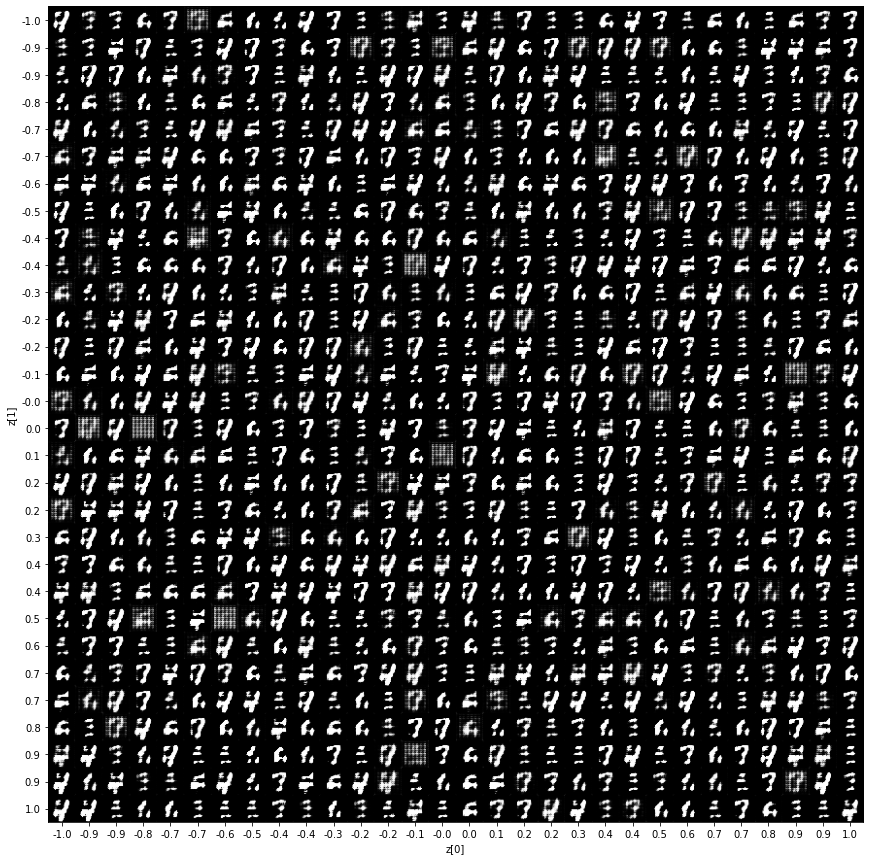

2021-12-29 17:30:00 INFO: 2050 -0.146 0.175
2021-12-29 17:30:00 INFO: 2100 -0.140 0.169
2021-12-29 17:30:00 INFO: 2150 -0.138 0.168
2021-12-29 17:30:00 INFO: 2200 -0.143 0.173
2021-12-29 17:30:01 INFO: 2250 -0.140 0.170
2021-12-29 17:30:01 INFO: 2300 -0.135 0.166
2021-12-29 17:30:01 INFO: 2350 -0.135 0.166
2021-12-29 17:30:01 INFO: 2400 -0.139 0.170
2021-12-29 17:30:02 INFO: 2450 -0.138 0.168
2021-12-29 17:30:02 INFO: 2500 -0.133 0.161
2021-12-29 17:30:02 INFO: 2550 -0.130 0.158
2021-12-29 17:30:02 INFO: 2600 -0.123 0.151
2021-12-29 17:30:03 INFO: 2650 -0.134 0.162
2021-12-29 17:30:03 INFO: 2700 -0.137 0.164
2021-12-29 17:30:03 INFO: 2750 -0.125 0.151
2021-12-29 17:30:03 INFO: 2800 -0.124 0.152
2021-12-29 17:30:04 INFO: 2850 -0.116 0.145
2021-12-29 17:30:04 INFO: 2900 -0.118 0.149
2021-12-29 17:30:04 INFO: 2950 -0.117 0.149
2021-12-29 17:30:04 INFO: 3000 -0.114 0.147
2021-12-29 17:30:05 INFO: 3050 -0.111 0.145
2021-12-29 17:30:05 INFO: 3100 -0.111 0.145
2021-12-29 17:30:05 INFO: 3150 -

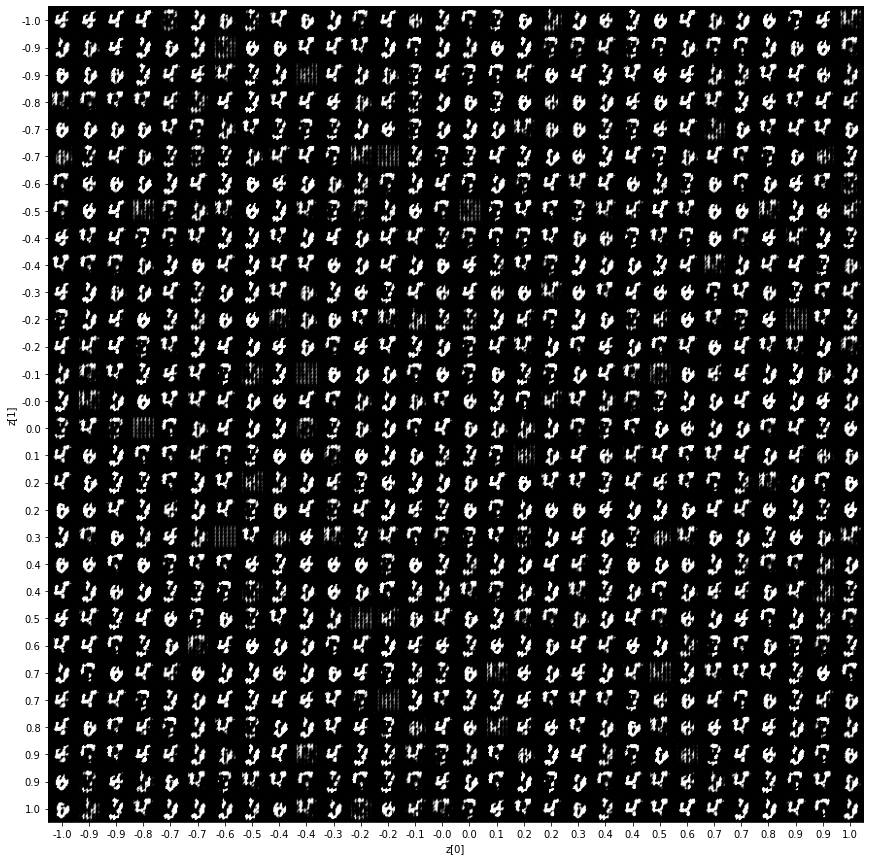

2021-12-29 17:30:10 INFO: 4050 -0.125 0.164
2021-12-29 17:30:11 INFO: 4100 -0.124 0.163
2021-12-29 17:30:11 INFO: 4150 -0.128 0.166
2021-12-29 17:30:11 INFO: 4200 -0.128 0.167
2021-12-29 17:30:11 INFO: 4250 -0.131 0.170
2021-12-29 17:30:12 INFO: 4300 -0.127 0.166
2021-12-29 17:30:12 INFO: 4350 -0.130 0.170
2021-12-29 17:30:12 INFO: 4400 -0.132 0.171
2021-12-29 17:30:13 INFO: 4450 -0.129 0.168
2021-12-29 17:30:13 INFO: 4500 -0.127 0.166
2021-12-29 17:30:13 INFO: 4550 -0.127 0.167
2021-12-29 17:30:13 INFO: 4600 -0.122 0.161
2021-12-29 17:30:14 INFO: 4650 -0.118 0.157
2021-12-29 17:30:14 INFO: 4700 -0.115 0.152
2021-12-29 17:30:14 INFO: 4750 -0.114 0.150
2021-12-29 17:30:14 INFO: 4800 -0.114 0.149
2021-12-29 17:30:15 INFO: 4850 -0.112 0.146
2021-12-29 17:30:15 INFO: 4900 -0.109 0.141
2021-12-29 17:30:15 INFO: 4950 -0.106 0.137
2021-12-29 17:30:15 INFO: 5000 -0.104 0.136
2021-12-29 17:30:16 INFO: 5050 -0.105 0.136
2021-12-29 17:30:16 INFO: 5100 -0.108 0.140
2021-12-29 17:30:16 INFO: 5150 -

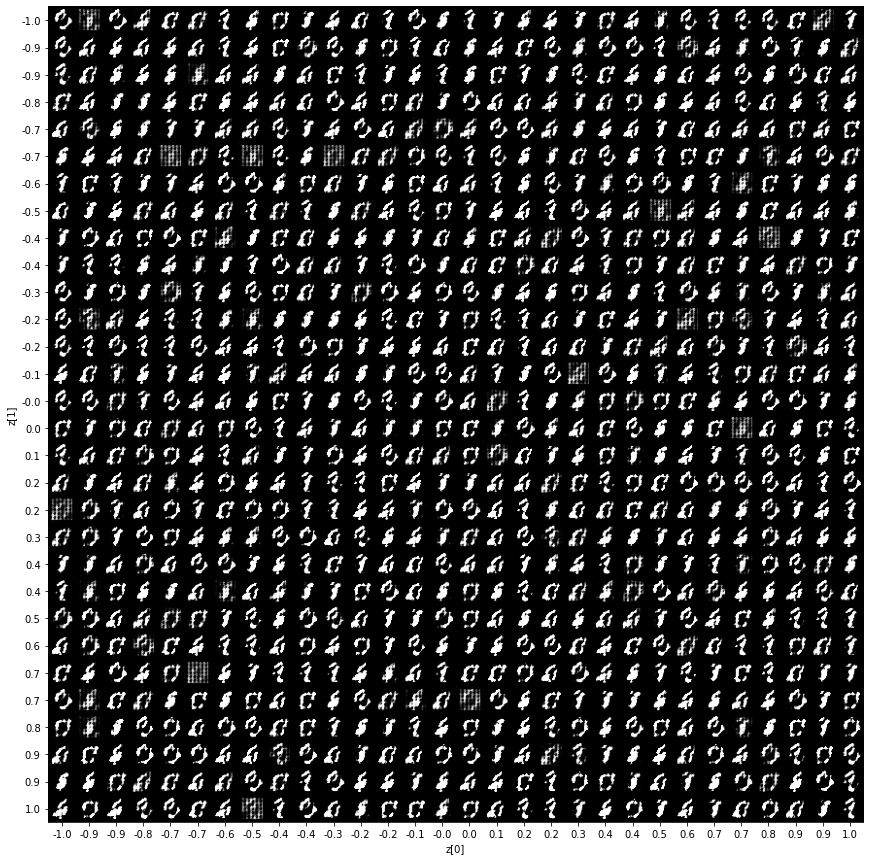

2021-12-29 17:30:21 INFO: 6050 -0.120 0.157
2021-12-29 17:30:22 INFO: 6100 -0.124 0.162
2021-12-29 17:30:22 INFO: 6150 -0.122 0.160
2021-12-29 17:30:22 INFO: 6200 -0.119 0.158
2021-12-29 17:30:22 INFO: 6250 -0.127 0.166
2021-12-29 17:30:23 INFO: 6300 -0.133 0.171
2021-12-29 17:30:23 INFO: 6350 -0.143 0.182
2021-12-29 17:30:23 INFO: 6400 -0.142 0.181
2021-12-29 17:30:23 INFO: 6450 -0.141 0.179
2021-12-29 17:30:24 INFO: 6500 -0.145 0.181
2021-12-29 17:30:24 INFO: 6550 -0.150 0.186
2021-12-29 17:30:24 INFO: 6600 -0.155 0.192
2021-12-29 17:30:24 INFO: 6650 -0.157 0.195
2021-12-29 17:30:25 INFO: 6700 -0.158 0.195
2021-12-29 17:30:25 INFO: 6750 -0.152 0.187
2021-12-29 17:30:25 INFO: 6800 -0.152 0.186
2021-12-29 17:30:25 INFO: 6850 -0.141 0.175
2021-12-29 17:30:26 INFO: 6900 -0.138 0.173
2021-12-29 17:30:26 INFO: 6950 -0.142 0.178
2021-12-29 17:30:26 INFO: 7000 -0.144 0.180
2021-12-29 17:30:27 INFO: 7050 -0.153 0.189
2021-12-29 17:30:27 INFO: 7100 -0.159 0.196
2021-12-29 17:30:27 INFO: 7150 -

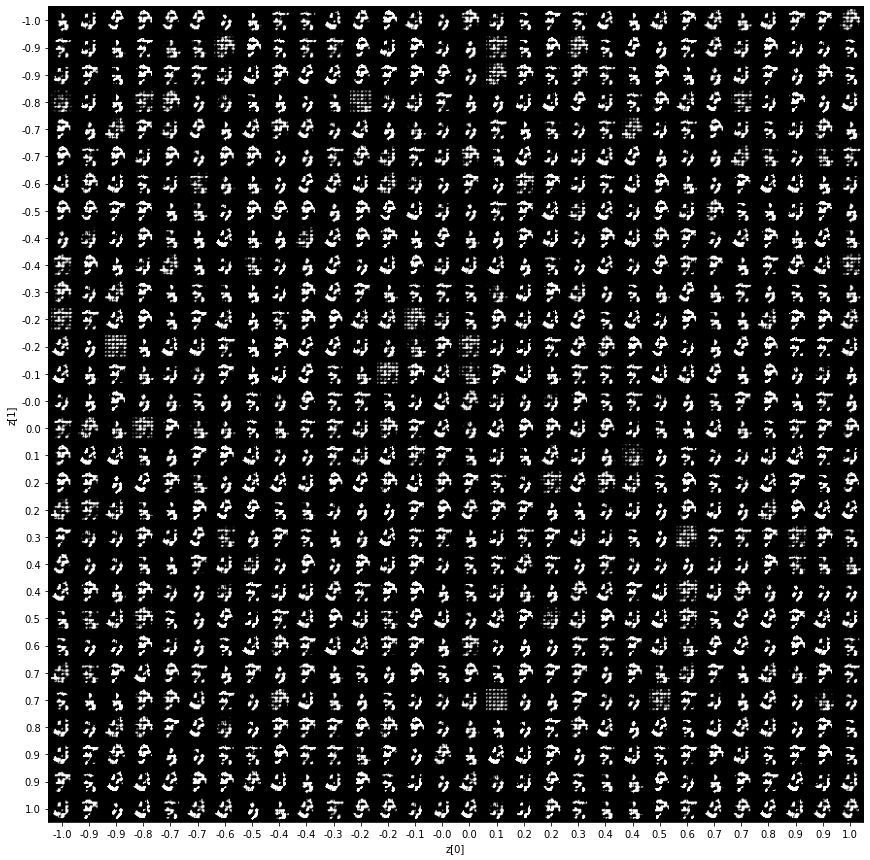

2021-12-29 17:30:32 INFO: 8050 -0.184 0.226
2021-12-29 17:30:33 INFO: 8100 -0.188 0.230
2021-12-29 17:30:33 INFO: 8150 -0.198 0.240
2021-12-29 17:30:33 INFO: 8200 -0.198 0.240
2021-12-29 17:30:33 INFO: 8250 -0.201 0.242
2021-12-29 17:30:34 INFO: 8300 -0.205 0.246
2021-12-29 17:30:34 INFO: 8350 -0.209 0.250
2021-12-29 17:30:34 INFO: 8400 -0.219 0.259
2021-12-29 17:30:34 INFO: 8450 -0.223 0.262
2021-12-29 17:30:35 INFO: 8500 -0.235 0.274
2021-12-29 17:30:35 INFO: 8550 -0.241 0.280
2021-12-29 17:30:35 INFO: 8600 -0.242 0.281
2021-12-29 17:30:36 INFO: 8650 -0.252 0.291
2021-12-29 17:30:36 INFO: 8700 -0.256 0.294
2021-12-29 17:30:36 INFO: 8750 -0.265 0.302
2021-12-29 17:30:36 INFO: 8800 -0.272 0.308
2021-12-29 17:30:37 INFO: 8850 -0.279 0.314
2021-12-29 17:30:37 INFO: 8900 -0.289 0.323
2021-12-29 17:30:37 INFO: 8950 -0.293 0.326
2021-12-29 17:30:37 INFO: 9000 -0.290 0.324
2021-12-29 17:30:38 INFO: 9050 -0.291 0.324
2021-12-29 17:30:38 INFO: 9100 -0.300 0.334
2021-12-29 17:30:38 INFO: 9150 -

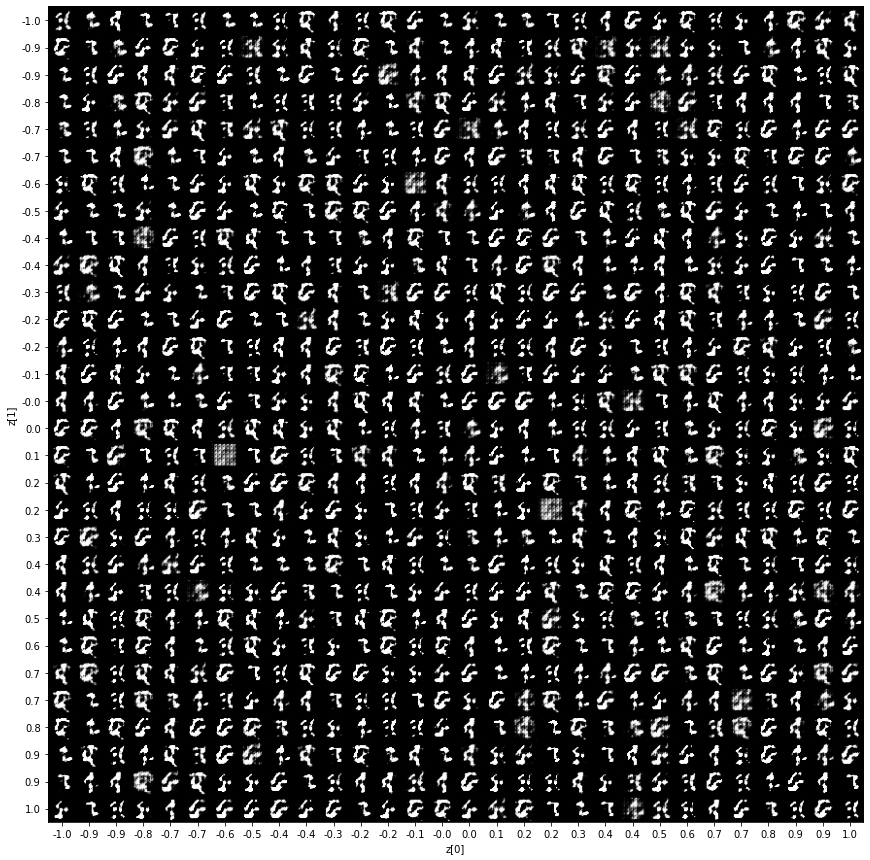

2021-12-29 17:30:43 INFO: 10050 -0.267 0.308
2021-12-29 17:30:44 INFO: 10100 -0.267 0.308
2021-12-29 17:30:44 INFO: 10150 -0.274 0.315
2021-12-29 17:30:44 INFO: 10200 -0.272 0.313
2021-12-29 17:30:44 INFO: 10250 -0.273 0.315
2021-12-29 17:30:45 INFO: 10300 -0.270 0.312
2021-12-29 17:30:45 INFO: 10350 -0.267 0.310
2021-12-29 17:30:45 INFO: 10400 -0.269 0.311
2021-12-29 17:30:46 INFO: 10450 -0.272 0.314
2021-12-29 17:30:46 INFO: 10500 -0.276 0.318
2021-12-29 17:30:46 INFO: 10550 -0.274 0.316
2021-12-29 17:30:46 INFO: 10600 -0.271 0.314
2021-12-29 17:30:47 INFO: 10650 -0.264 0.308
2021-12-29 17:30:47 INFO: 10700 -0.261 0.306
2021-12-29 17:30:47 INFO: 10750 -0.255 0.301
2021-12-29 17:30:47 INFO: 10800 -0.248 0.294
2021-12-29 17:30:48 INFO: 10850 -0.245 0.292
2021-12-29 17:30:48 INFO: 10900 -0.243 0.290
2021-12-29 17:30:48 INFO: 10950 -0.235 0.282
2021-12-29 17:30:48 INFO: 11000 -0.230 0.276
2021-12-29 17:30:49 INFO: 11050 -0.235 0.282
2021-12-29 17:30:49 INFO: 11100 -0.239 0.284
2021-12-29

KeyboardInterrupt: 

In [20]:
wd_loss = 100
wg_loss = 100
count = 0

lossf = nn.BCELoss()

while True:
    count += 1
    gamma = max(1 / count, GAMMA)

    G.train()
    D.train()

    idx = torch.randint(train.shape[0], (BATCH_SIZE,))
    real = train[idx]
    fake = gen(BATCH_SIZE)

    vf = torch.full((BATCH_SIZE, 1,), 1, dtype=torch.float, device=device)
    ff = torch.full((BATCH_SIZE, 1,), -1, dtype=torch.float, device=device)
    
    if np.random.uniform() < 0.5:
        x = torch.cat((real, fake), 1)
    else:
        x = torch.cat((fake, real), 1)
        vf, ff = ff, vf

    DO.zero_grad()

    d_loss = (D(x) * vf).mean()
    d_loss.backward(retain_graph=True)

    DO.step()
    wd_loss = d_loss.item() * gamma + wd_loss * (1 - gamma)
    
    GO.zero_grad()

    g_loss = (D(x) * ff).mean()
    g_loss.backward()

    GO.step()
    wg_loss = g_loss.item() * gamma + wg_loss * (1 - gamma)

    if count % LOG_INT == 0:
        logging.info(f'{count} {wd_loss:.3f} {wg_loss:.3f}')

    if count % 2000 == 0:
        G.eval()
        plot_latent_space()